## Predicting

**Importing librairies**


In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd


https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [2]:
filename_1 = "..\data\_tarefelt1.csv"
filename_2 = "..\data\_tarefelt2.csv"
filename_3 = "..\data\_tarefelt3.csv"

In [3]:
data_1 = pd.read_csv(filename_1)
data_2 = pd.read_csv(filename_2)
data_3 = pd.read_csv(filename_3)

X =  pd.concat([data_1, data_2, data_3])

'\nX_train, X_test ,y_train, y_test = train_test_split( X, y, test_size=0.10, random_state = 42)\n\nlat, lon = X.drop(columns = "lat"), X.drop(columns =  "lon") \ny = X.label\n\n'

**Splitting data**

Creating balanced datasets using stratified shuffle split

In [17]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

for i, (train_index, test_index) in enumerate(sss.split(X, X.label)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]


Fold 0:
  Train: index=[2572691 1311439 1299395 ... 2998718  570150  512059]
  Test:  index=[ 461387 2301546  469403 ... 2798718 2431466  634462]


**Feature extracting**

In [18]:
y_train = X_train.label
X_train.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

In [19]:
lat = X_test.lat
lon = X_test.lon
y_test = X_test.label
X_test.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

**Standarscaling**


In [20]:
scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)

**Training the model**  


In [21]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


In [23]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss = "log_loss",  verbose = 50, warm_start = True, penalty = "elasticnet", max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))

classes = np.unique(y_train)
accuracy =[]
ROUNDS = 1
count = 0 
batchsize = 10000

sss = StratifiedShuffleSplit(n_splits=ROUNDS, test_size=0.5, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_train, y_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
    X_sgd = X_train.iloc[train_index]
    y_sgd = y_train.iloc[train_index]
    batcherator= batch(X_sgd, y_sgd, batchsize)

    for index, (x_batch, y_batch) in enumerate(batcherator):
        print(count)
        count+= 1
        clf.partial_fit(x_batch, y_batch, classes)
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))

Fold 0:
  Train: index=[ 793660  590401   12166 ...  924143 1365328 1426408]
  Test:  index=[ 490848 2116977 1604013 ... 1752762 2006707 1064506]
0
-- Epoch 1
Norm: 260.32, NNZs: 64, Bias: -189.805838, T: 10000, Avg. loss: 242.976882
Total training time: 0.01 seconds.
1
-- Epoch 1
Norm: 161.60, NNZs: 64, Bias: -138.089422, T: 10000, Avg. loss: 64.859205
Total training time: 0.00 seconds.
2
-- Epoch 1
Norm: 111.33, NNZs: 64, Bias: -67.520030, T: 10000, Avg. loss: 34.142311
Total training time: 0.01 seconds.
3
-- Epoch 1
Norm: 94.07, NNZs: 64, Bias: -61.861249, T: 10000, Avg. loss: 24.146712
Total training time: 0.01 seconds.
4
-- Epoch 1
Norm: 87.56, NNZs: 64, Bias: -63.109485, T: 10000, Avg. loss: 18.415926
Total training time: 0.01 seconds.
5
-- Epoch 1
Norm: 84.09, NNZs: 63, Bias: -75.978930, T: 10000, Avg. loss: 13.506381
Total training time: 0.01 seconds.
6
-- Epoch 1
Norm: 77.38, NNZs: 64, Bias: -55.611331, T: 10000, Avg. loss: 9.726519
Total training time: 0.01 seconds.
7
-- Epoc

**Plotting accuracy**

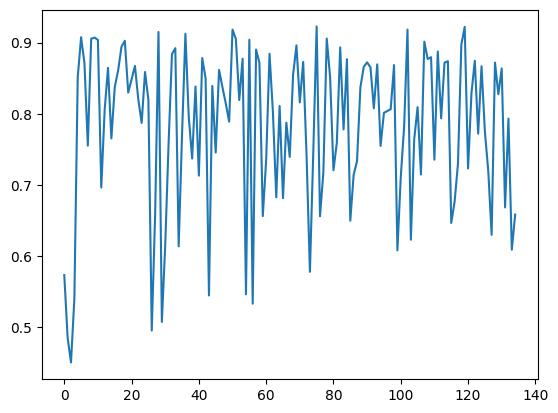

In [24]:
plt.plot(accuracy)

**Evaluating Model**


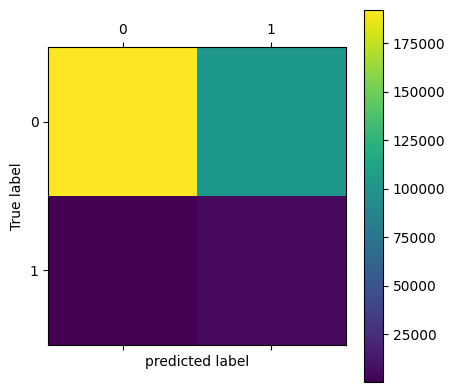

In [25]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [26]:
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.66


In [27]:
np.unique(y_predicted)

array([0., 1.])

In [28]:
y_test.value_counts()


0.0    294347
1.0      5653
Name: label, dtype: int64

<AxesSubplot:>

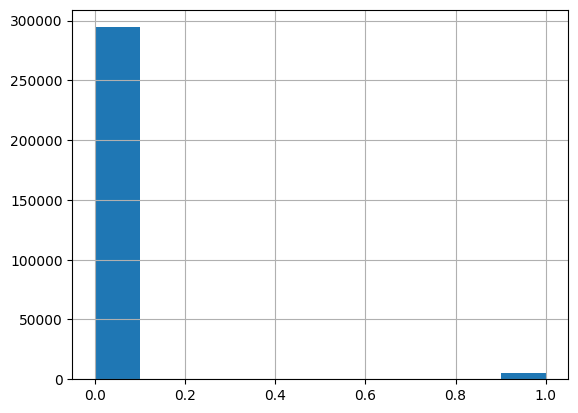

In [29]:
y_test.hist()

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [32]:
X_final = X_test.copy()
X_final["label"] = y_test
X_final["y_predicted"] = y_predicted
X_final = gpd.GeoDataFrame(X_final, geometry=gpd.points_from_xy(lon, lat))

df_no_seaweed = X_final[X_final["y_predicted"] == 0].copy()
df_seaweed = X_final[X_final["y_predicted"] == 1].copy()
df_true_seaweed = X_final[X_final["label"] == True].copy()

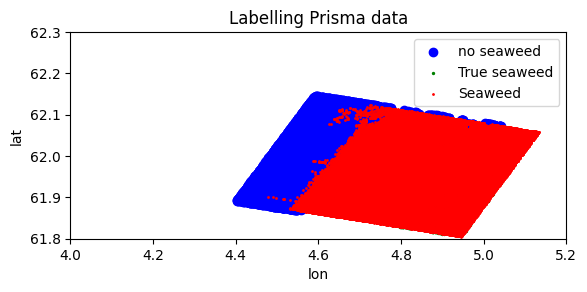

In [35]:
fig, ax = plt.subplots()
df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 2)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.set_ylim(61.8, 62.3)
ax.set_xlim(4,5.2)
ax.legend()